In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.autograd.variable import Variable

In [15]:
df = pd.read_excel("../Data/CallCenterData.xlsx", index_col=0)

In [16]:
df.tail()

,CallCount,Acht,freq,freq_100,year,month,day,hour,weekday,weekend,quarter
2020-11-01 19:00:00,47,660,0.0625,6.25,2020,11,1,19,7,1,4
2020-11-01 20:00:00,23,504,0.0306,3.06,2020,11,1,20,7,1,4
2020-11-01 21:00:00,40,665,0.0532,5.32,2020,11,1,21,7,1,4
2020-11-01 22:00:00,24,692,0.0319,3.19,2020,11,1,22,7,1,4
2020-11-01 23:00:00,17,635,0.0226,2.26,2020,11,1,23,7,1,4


In [19]:
series = df.freq.values

In [31]:
# Whole batch length
len(series)/7/24

148.0

In [29]:
# See if it did shape accordingly
np.sum(series[:7*24].reshape(-1,24), axis=1)

array([1.    , 0.9999, 0.9999, 1.0001, 0.9997, 1.0001, 1.0001])

In [37]:
# Create whole batches as according to our needs
arr = []
step = 7
for i in range(0, int(len(series)/24), step):
    arr.append(series[i*24:(i+step)*24].reshape(step,24))
arr = np.array(arr)

In [48]:
# Correct shape
arr.shape

(148, 7, 24)

In [57]:
np.prod((arr.shape[1], arr.shape[2]))

168

In [82]:
np.prod(1)

1

In [49]:
# Data Loader for torch
data_loader = torch.utils.data.DataLoader(arr, batch_size=10, shuffle=False)
num_batches = len(data_loader) # DataLoader.__len__() and 148/10 = 15 batch count

In [92]:
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        
        in_features = np.prod(in_features) # Tuple, list, integer etc.. if (7,24) = 7*24 else it will return num
        self.model = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.02),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)
    
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        
        z_dim = np.prod(z_dim)
        img_dim = np.prod(img_dim)
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.02),
            nn.Linear(256, img_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)
    

In [93]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 64
image_dim = 7 * 24
batch_size = 32

In [146]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((1, z_dim)).to(device)

In [147]:
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
loss = nn.BCELoss()

In [176]:
num_epochs = 100
for epoch in range(num_epochs):
    for batch_idx, real in enumerate(data_loader):
        real = real.view(-1, image_dim).to(device)
        batch_size = real.shape[0]
        
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        
        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real.float()).view(-1)
        lossD_real = loss(disc_real, torch.ones_like(disc_real))
        
        disc_fake = disc(fake).view(-1)
        lossD_fake = loss(disc_fake, torch.zeros_like(disc_fake))
        
        lossD = (lossD_real + lossD_fake)/2
        
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()
        
        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        
        output = disc(fake).view(-1)
        lossG = loss(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()
        
    if not(epoch % 5):
        print(f"Epoch [{epoch}/{num_epochs}] Loss D: {lossD:.4f}, loss G: {lossG:.4f}")

Epoch [0/100] Loss D: 0.6426, loss G: 0.7346
Epoch [5/100] Loss D: 0.6403, loss G: 0.7777
Epoch [10/100] Loss D: 0.5973, loss G: 0.8584
Epoch [15/100] Loss D: 0.5641, loss G: 0.9323
Epoch [20/100] Loss D: 0.6199, loss G: 0.7907
Epoch [25/100] Loss D: 0.5654, loss G: 0.8824
Epoch [30/100] Loss D: 0.6023, loss G: 0.8889
Epoch [35/100] Loss D: 0.5981, loss G: 0.8066
Epoch [40/100] Loss D: 0.5982, loss G: 0.8472
Epoch [45/100] Loss D: 0.6129, loss G: 0.7994
Epoch [50/100] Loss D: 0.6088, loss G: 0.8013
Epoch [55/100] Loss D: 0.6020, loss G: 0.7846
Epoch [60/100] Loss D: 0.6089, loss G: 0.8018
Epoch [65/100] Loss D: 0.6582, loss G: 0.7550
Epoch [70/100] Loss D: 0.5877, loss G: 0.8975
Epoch [75/100] Loss D: 0.5886, loss G: 0.8961
Epoch [80/100] Loss D: 0.5566, loss G: 0.8832
Epoch [85/100] Loss D: 0.6202, loss G: 0.7576
Epoch [90/100] Loss D: 0.6436, loss G: 0.7360
Epoch [95/100] Loss D: 0.6007, loss G: 0.8598


In [177]:
s = np.mean(gen(torch.randn(100000, z_dim).to(device)).detach().numpy(), axis=0).reshape(7,24)
d = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
asd = pd.DataFrame({d[i]:j*100 for i,j in enumerate(s)})

In [178]:
# Freqs by days (average of 100000 outputs)
asd

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,0.301682,0.930768,1.569379,0.616025,0.281221,1.293839,1.754147
1,0.516919,0.256922,0.134980,0.108983,0.166580,0.129641,11.198625
2,0.067465,0.127190,1.204425,0.407703,0.085259,0.119428,0.116376
3,0.020417,0.026954,0.025604,0.024241,0.046836,0.078236,0.091622
4,0.021831,0.052860,0.022713,0.026491,0.016934,0.047353,0.048826
5,0.077707,0.028690,0.028951,0.027720,0.020374,0.057452,0.073804
6,1.260702,0.096456,0.064868,0.246211,0.193845,0.085399,0.094404
7,0.517990,0.890125,0.171088,0.226342,0.886898,0.918038,1.072047
8,11.063747,2.434913,4.556303,1.583542,0.758663,1.018857,0.779222
9,5.479805,2.947328,5.995458,6.620911,5.185590,6.941873,8.397350


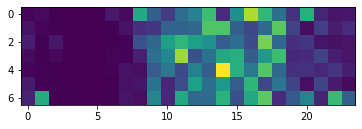

In [179]:
plt.imshow(s)

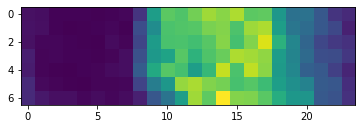

In [180]:
r = np.random.randint(len(arr))
plt.imshow(arr[r])